Imports & Settings

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", None)


Load Dataset + Backup

In [4]:
DATA_PATH = "Indian_Climate_Dataset_2024_2025.csv"
df = pd.read_csv(DATA_PATH)

os.makedirs("data", exist_ok=True)
df.to_csv("data/raw_backup.csv", index=False)

print("Raw backup saved")
df.head()


Raw backup saved


,Date,City,State,Temperature_Max (°C),Temperature_Min (°C),Temperature_Avg (°C),Humidity (%),Rainfall (mm),Wind_Speed (km/h),AQI,AQI_Category,Pressure (hPa),Cloud_Cover (%)
0,2024-01-01,Mumbai,Maharashtra,32.5,18.0,25.2,77.6,0.0,3.3,259,Poor,1020.3,62.1
1,2024-01-01,Delhi,Delhi,25.4,10.7,18.1,84.1,0.0,9.0,130,Moderate,1008.4,46.0
2,2024-01-01,Bengaluru,Karnataka,37.2,30.8,34.0,49.0,3.7,6.6,54,Satisfactory,1008.0,61.3
3,2024-01-01,Chennai,Tamil Nadu,37.2,30.4,33.8,34.2,9.5,9.0,176,Moderate,993.4,70.0
4,2024-01-01,Kolkata,West Bengal,27.4,17.5,22.5,32.2,9.1,9.2,97,Satisfactory,1008.2,56.9


Column Name Cleaning

In [5]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
)

df.columns


Index(['date', 'city', 'state', 'temperature_max_(°c)', 'temperature_min_(°c)',
       'temperature_avg_(°c)', 'humidity_(%)', 'rainfall_(mm)',
       'wind_speed_(km/h)', 'aqi', 'aqi_category', 'pressure_(hpa)',
       'cloud_cover_(%)'],
      dtype='object')

Convert Numeric Columns

In [6]:
num_keywords = ["temp", "rain", "humid", "wind", "cloud", "aqi", "pressure"]

for c in df.columns:
    if any(k in c for k in num_keywords):
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7310 entries, 0 to 7309
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  7310 non-null   object 
 1   city                  7310 non-null   object 
 2   state                 7310 non-null   object 
 3   temperature_max_(°c)  7310 non-null   float64
 4   temperature_min_(°c)  7310 non-null   float64
 5   temperature_avg_(°c)  7310 non-null   float64
 6   humidity_(%)          7310 non-null   float64
 7   rainfall_(mm)         7310 non-null   float64
 8   wind_speed_(km/h)     7310 non-null   float64
 9   aqi                   7310 non-null   int64  
 10  aqi_category          0 non-null      float64
 11  pressure_(hpa)        7310 non-null   float64
 12  cloud_cover_(%)       7310 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 742.6+ KB


Rename Important Columns

In [7]:
df = df.rename(columns={
    "temperature_avg_(°c)": "avg_temperature",
    "rainfall_(mm)": "rainfall",
    "humidity_(%)": "humidity",
    "wind_speed_(km/h)": "wind_speed",
    "cloud_cover_(%)": "cloud_cover"
})


Date & Time Features

In [8]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"]   = df["date"].dt.day
df["week"]  = df["date"].dt.isocalendar().week.astype(int)

season_map = {
    12:'winter',1:'winter',2:'winter',
    3:'summer',4:'summer',5:'summer',
    6:'monsoon',7:'monsoon',8:'monsoon',
    9:'post-monsoon',10:'post-monsoon',11:'post-monsoon'
}

df["season"] = df["month"].map(season_map)

df[['date','year','month','season']].head()


,date,year,month,season
0,2024-01-01,2024,1,winter
1,2024-01-01,2024,1,winter
2,2024-01-01,2024,1,winter
3,2024-01-01,2024,1,winter
4,2024-01-01,2024,1,winter


Clean City & State Strings

In [9]:
for c in ["state", "city"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title()


Remove Duplicate Rows

In [10]:
before = len(df)
df = df.drop_duplicates()
after = len(df)

print(f"Removed {before - after} duplicate rows")


Removed 0 duplicate rows


Outlier Capping

In [11]:
def cap_outliers(s):
    q1, q3 = np.percentile(s.dropna(), [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return s.clip(lo, hi)

num_cols = [
    "avg_temperature","rainfall","humidity",
    "wind_speed","cloud_cover","aqi"
]

for c in num_cols:
    if c in df.columns:
        df[c] = cap_outliers(df[c])


Select Final Columns

In [12]:
keep_cols = [
    "date","state","city",
    "avg_temperature","rainfall","humidity",
    "wind_speed","cloud_cover","aqi",
    "year","month","week","season"
]

df = df[keep_cols]
df.head()


,date,state,city,avg_temperature,rainfall,humidity,wind_speed,cloud_cover,aqi,year,month,week,season
0,2024-01-01,Maharashtra,Mumbai,25.2,0.0,77.6,3.3,62.1,259,2024,1,1,winter
1,2024-01-01,Delhi,Delhi,18.1,0.0,84.1,9.0,46.0,130,2024,1,1,winter
2,2024-01-01,Karnataka,Bengaluru,34.0,3.7,49.0,6.6,61.3,54,2024,1,1,winter
3,2024-01-01,Tamil Nadu,Chennai,33.8,9.5,34.2,9.0,70.0,176,2024,1,1,winter
4,2024-01-01,West Bengal,Kolkata,22.5,9.1,32.2,9.2,56.9,97,2024,1,1,winter


Stress Level Creation

In [13]:
def stress_label(row):
    score = 0

    if row["avg_temperature"] > 35: score += 2
    elif row["avg_temperature"] > 30: score += 1

    if row["humidity"] < 30 or row["humidity"] > 85: score += 2

    if row["rainfall"] == 0: score += 2
    elif row["rainfall"] > 150: score += 2
    elif row["rainfall"] > 80: score += 1

    if row["aqi"] > 200: score += 1
    if row["wind_speed"] > 20: score += 1
    if row["cloud_cover"] < 20: score += 1

    if score <= 2:
        return "Healthy"
    elif score <= 4:
        return "Mild Stress"
    else:
        return "Severe Stress"

df["stress_level"] = df.apply(stress_label, axis=1)
df["stress_level"].value_counts()


stress_level
Mild Stress      3161
Healthy          2720
Severe Stress    1429
Name: count, dtype: int64

In [14]:
FINAL_PATH = "data/climate_clean_labeled.csv"
df.to_csv(FINAL_PATH, index=False)

print("Saved →", FINAL_PATH)


Saved → data/climate_clean_labeled.csv


Missing Value Analysis

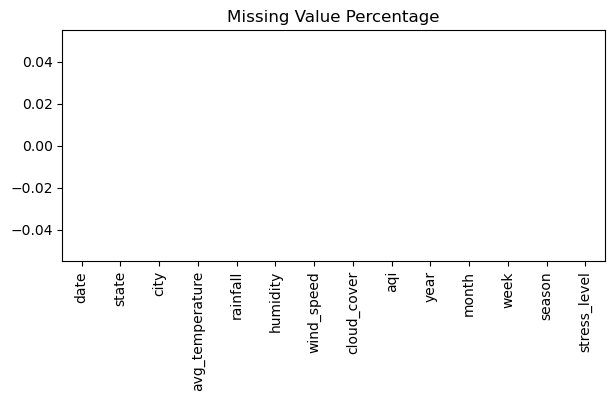

In [15]:
df.isna().mean().plot(kind="bar", figsize=(7,3))
plt.title("Missing Value Percentage")
plt.show()


Stress Level Distribution

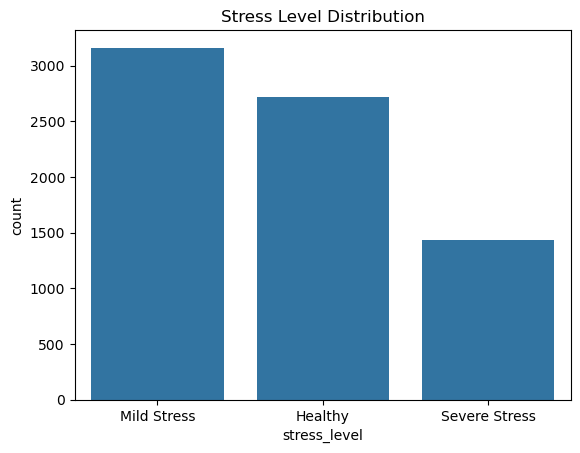

In [16]:
sns.countplot(data=df, x="stress_level")
plt.title("Stress Level Distribution")
plt.show()


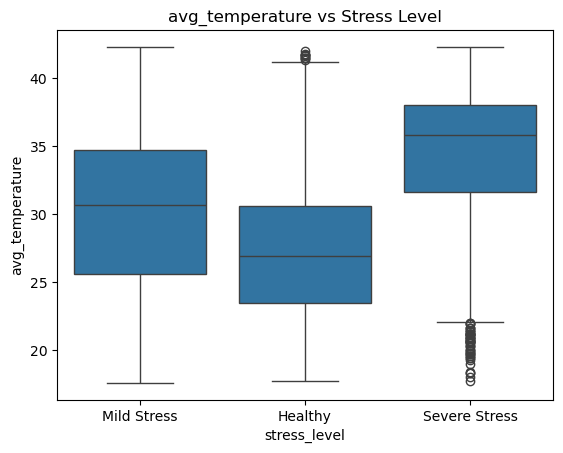

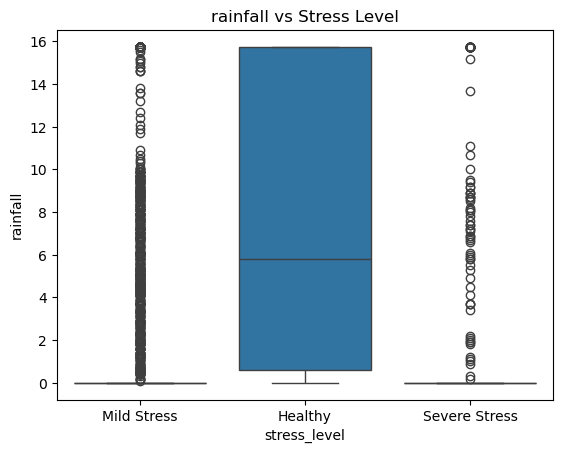

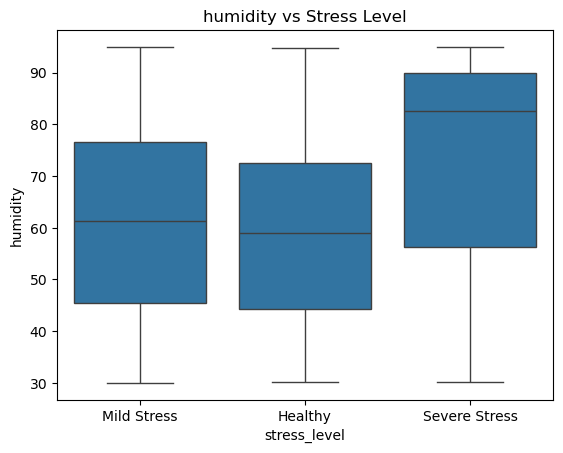

In [17]:
for c in ["avg_temperature","rainfall","humidity"]:
    sns.boxplot(data=df, x="stress_level", y=c)
    plt.title(f"{c} vs Stress Level")
    plt.show()


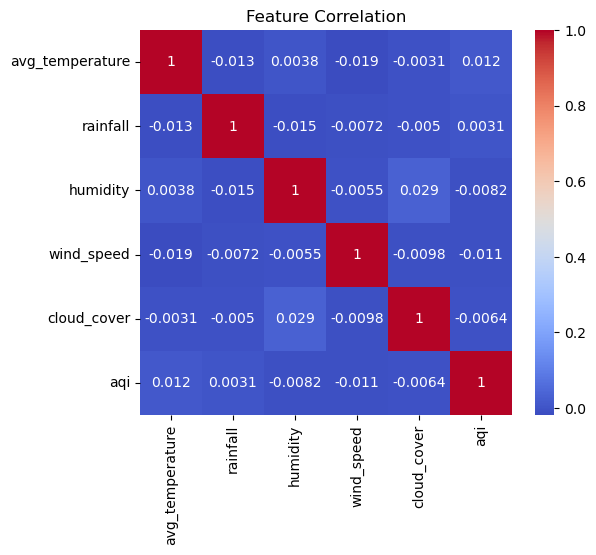

In [18]:
corr = df[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


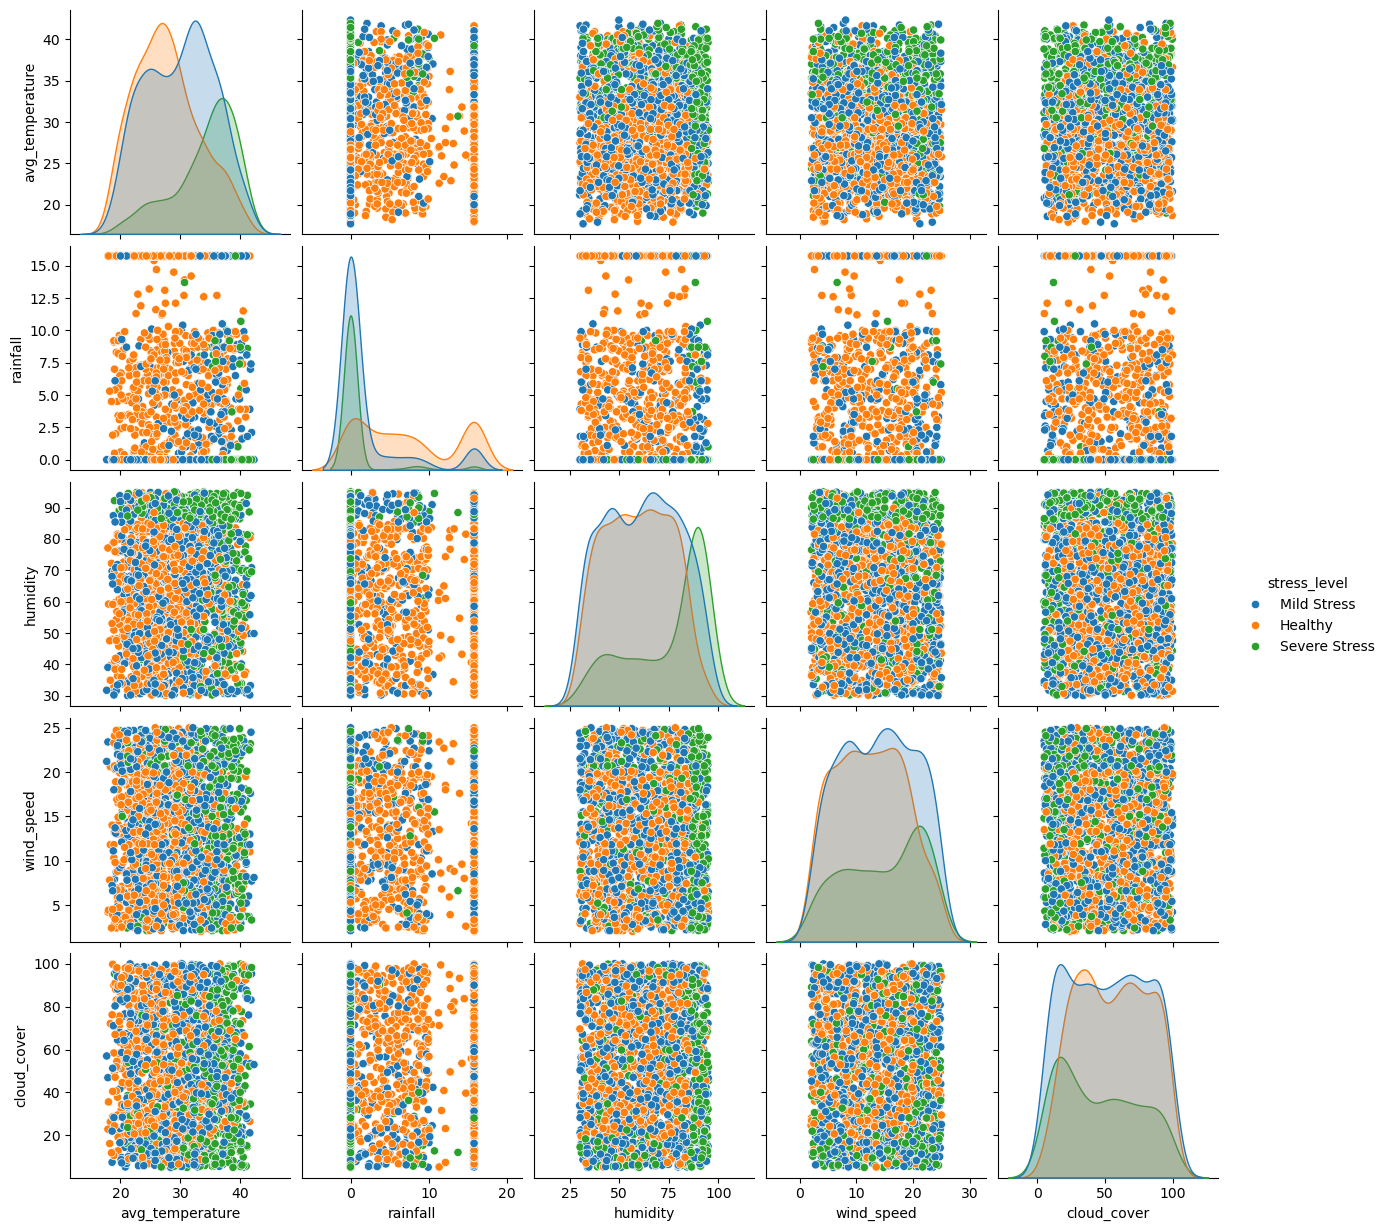

In [19]:
sns.pairplot(
    df.sample(2000, random_state=42),
    vars=["avg_temperature","rainfall","humidity","wind_speed","cloud_cover"],
    hue="stress_level"
)
plt.show()
